In [108]:
import cv2

import os
import numpy as np
from utils import get_bounding_box_dims
from utils import IOU
import numpy as np
from matplotlib import pyplot as plt


In [109]:
image_list = os.listdir(inp_path)
org_image = cv2.imread(os.path.join(inp_path,image_list[0]))
gt_file = open(gt_path,'r')
gt_file_content = gt_file.readlines()
gt_box_dims = get_bounding_box_dims(gt_file_content, 1)
template = org_image[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [110]:
p = np.zeros([1,6], dtype = np.float64)

In [111]:
W = np.array([[1+p[0,0],p[0,2],p[0,4]],
                    [p[0,1], 1+p[0,3],p[0,5]]])

In [112]:
frame = cv2.imread(os.path.join(inp_path,image_list[1]))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.warpAffine(frame, W, (frame.shape[1], frame.shape[0]))
input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]

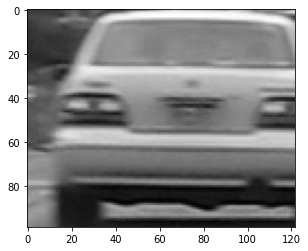

In [113]:
plt.imshow(input_frame,cmap='gray')


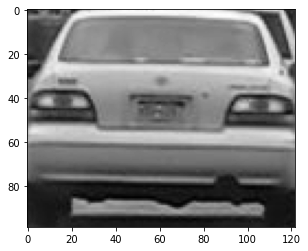

In [114]:
plt.imshow(template,cmap='gray')

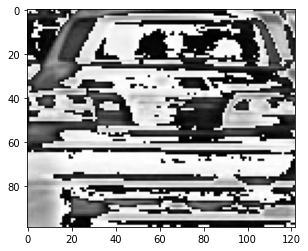

In [115]:
diff = template-input_frame
plt.imshow(diff,cmap='gray')

In [119]:
gradX = cv2.Sobel(input_frame, cv2.CV_64F, 1, 0, ksize=5)
gradY = cv2.Sobel(input_frame, cv2.CV_64F, 0, 1, ksize=5)
Height, Weight = template.shape
Xc = np.tile(np.linspace(0, Weight-1, Weight), (Height, 1)).flatten()
Yc = np.tile(np.linspace(0, Height-1, Height), (Weight, 1)).T.flatten()
print(Xc)
print(Xc.shape)
print(Yc)
print(Yc.shape)

[  0.   1.   2. ... 119. 120. 121.]
(12078,)
[ 0.  0.  0. ... 98. 98. 98.]
(12078,)


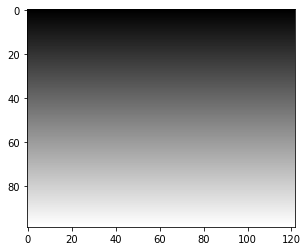

In [94]:
gradX = cv2.Sobel(input_frame, cv2.CV_64F, 1, 0, ksize=5)
gradY = cv2.Sobel(input_frame, cv2.CV_64F, 0, 1, ksize=5)

ht, wt = template.shape

Xc = np.tile(np.linspace(0, wt-1, wt), (ht, 1))
plt.imshow(Xc,cmap='gray')
Yc = np.tile(np.linspace(0, ht-1, ht), (wt, 1)).T
plt.imshow(Yc,cmap='gray')

In [96]:
steepestDescentImages=[]
steepestDescentImages.append(np.multiply(Xc,gradX))
steepestDescentImages.append(np.multiply(Xc,gradY))
steepestDescentImages.append(np.multiply(Yc,gradX))
steepestDescentImages.append(np.multiply(Yc,gradY))
steepestDescentImages.append(gradX)
steepestDescentImages.append(gradY)
steepDescent=np.array(steepestDescentImages,np.uint8)



(99, 122)


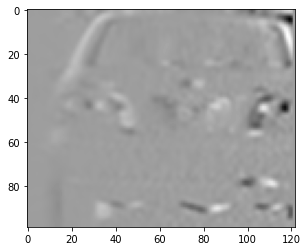

In [106]:
print(steepestDescentImages[0].shape)
plt.imshow(steepestDescentImages[0],cmap='gray')


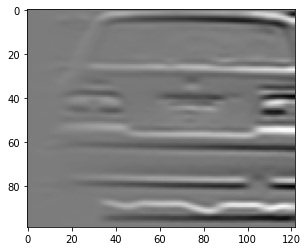

In [101]:
plt.imshow(steepestDescentImages[1],cmap='gray')

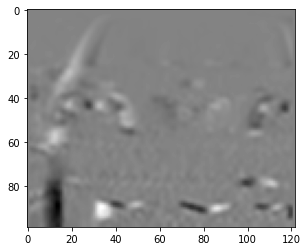

In [102]:
plt.imshow(steepestDescentImages[2],cmap='gray')

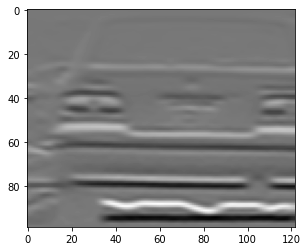

In [103]:
plt.imshow(steepestDescentImages[3],cmap='gray')

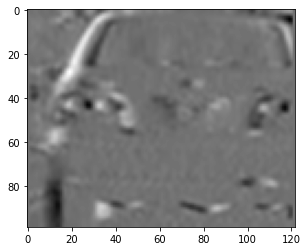

In [104]:
plt.imshow(steepestDescentImages[4],cmap='gray')

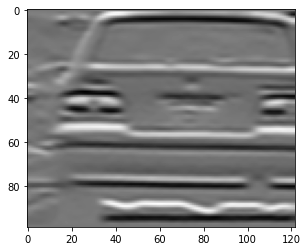

In [105]:
plt.imshow(steepestDescentImages[5],cmap='gray')

SyntaxError: invalid syntax (Temp/ipykernel_6216/1178389389.py, line 1)

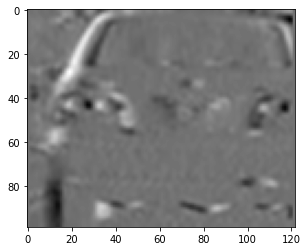

In [88]:
plt.imshow(gradX,cmap='gray')


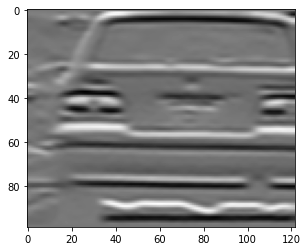

In [89]:
plt.imshow(gradY,cmap='gray')


In [93]:
steepest_descent = np.vstack([gradX.ravel() * Xc, gradY.ravel() * Xc,gradX.ravel()*Yc, gradY.ravel()*Yc, gradX.ravel(), gradY.ravel()]).T
print(steepest_descent.shape)

(12078, 6)


In [121]:
l=[]
for i in range(6):
    l.append(steepestDescentImages[i].ravel())
steepDes=np.array(l).T
print(steepDes.shape)

(12078, 6)


In [126]:
l_2=[]
for i in range(6):
    for j in range(6):
        a=steepestDescentImages[i]
        b=steepestDescentImages[j]
        c=np.multiply(a,b)
        l_2.append(np.sum(c))
l_2=np.array(l_2)
hess_3=l_2.reshape((6,6))
print(hess_3)
print(hess_3 == hessian)

[[ 7.46502797e+12 -4.63547051e+12  4.44089501e+12 -1.66559650e+12
   1.06495288e+11 -3.75130351e+10]
 [-4.63547051e+12  2.03755173e+14 -1.66559650e+12  1.38549597e+14
  -3.75130351e+10  2.44632575e+12]
 [ 4.44089501e+12 -1.66559650e+12  7.57040701e+12 -1.51141170e+12
   1.16994640e+11 -1.57721311e+10]
 [-1.66559650e+12  1.38549597e+14 -1.51141170e+12  1.42761867e+14
  -1.57721311e+10  1.97742316e+12]
 [ 1.06495288e+11 -3.75130351e+10  1.16994640e+11 -1.57721311e+10
   2.64243126e+09  5.97319700e+06]
 [-3.75130351e+10  2.44632575e+12 -1.57721311e+10  1.97742316e+12
   5.97319700e+06  3.55163558e+10]]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]


In [123]:
hess_2=np.matmul(steepest_descent.T, steepest_descent)
det_hess = np.linalg.det(hessian)
if det_hess == 0:
    pass
print(hess_2)

[[ 7.46502797e+12 -4.63547051e+12  4.44089501e+12 -1.66559650e+12
   1.06495288e+11 -3.75130351e+10]
 [-4.63547051e+12  2.03755173e+14 -1.66559650e+12  1.38549597e+14
  -3.75130351e+10  2.44632575e+12]
 [ 4.44089501e+12 -1.66559650e+12  7.57040701e+12 -1.51141170e+12
   1.16994640e+11 -1.57721311e+10]
 [-1.66559650e+12  1.38549597e+14 -1.51141170e+12  1.42761867e+14
  -1.57721311e+10  1.97742316e+12]
 [ 1.06495288e+11 -3.75130351e+10  1.16994640e+11 -1.57721311e+10
   2.64243126e+09  5.97319700e+06]
 [-3.75130351e+10  2.44632575e+12 -1.57721311e+10  1.97742316e+12
   5.97319700e+06  3.55163558e+10]]


In [122]:
hessian = np.matmul(steepest_descent.T, steepest_descent)
det_hessian = np.linalg.det(hessian)
if det_hessian == 0:
    pass
print(hessian)

[[ 7.46502797e+12 -4.63547051e+12  4.44089501e+12 -1.66559650e+12
   1.06495288e+11 -3.75130351e+10]
 [-4.63547051e+12  2.03755173e+14 -1.66559650e+12  1.38549597e+14
  -3.75130351e+10  2.44632575e+12]
 [ 4.44089501e+12 -1.66559650e+12  7.57040701e+12 -1.51141170e+12
   1.16994640e+11 -1.57721311e+10]
 [-1.66559650e+12  1.38549597e+14 -1.51141170e+12  1.42761867e+14
  -1.57721311e+10  1.97742316e+12]
 [ 1.06495288e+11 -3.75130351e+10  1.16994640e+11 -1.57721311e+10
   2.64243126e+09  5.97319700e+06]
 [-3.75130351e+10  2.44632575e+12 -1.57721311e+10  1.97742316e+12
   5.97319700e+06  3.55163558e+10]]


In [128]:
l_3=[]
for i in range(6):
    a=steepestDescentImages[i]
    c=np.multiply(a,diff)
    l_3.append(np.sum(c))
l_3=np.array(l_3)
print(l_3)

[-2.81133821e+09 -4.99811039e+10 -4.96658284e+09 -4.48739819e+10
 -4.55694330e+07 -7.16387493e+08]


In [129]:
print(np.matmul(steepest_descent.T, diff.flatten()))

[-2.81133821e+09 -4.99811039e+10 -4.96658284e+09 -4.48739819e+10
 -4.55694330e+07 -7.16387493e+08]


In [130]:
delp_1 = np.matmul(np.linalg.inv(hessian),l_3)
print(delp_1)

[-6.40702872e-04  7.53614450e-06 -1.45030219e-03 -1.37511002e-04
  7.21077080e-02 -1.43664992e-02]


In [92]:
delp = np.matmul(np.linalg.inv(hessian), np.matmul(steepest_descent.T, diff.flatten()))
print(delp)

[-6.40702872e-04  7.53614450e-06 -1.45030219e-03 -1.37511002e-04
  7.21077080e-02 -1.43664992e-02]


In [71]:
W= W + np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]) 
print(np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]))

[[-6.40702872e-04 -1.45030219e-03  7.21077080e-02]
 [ 7.53614450e-06 -1.37511002e-04 -1.43664992e-02]]


In [68]:
def afflineInv(prevWarp):
    R = prevWarp[:,0:2]
    rinv = np.linalg.inv(R)
    trans = np.matmul(rinv,prevWarp[:,2])
    pinv = np.array( [ [rinv[0,0], rinv[0,1] , -trans[0]],  [rinv[1,0], rinv[1,1] , -trans[1]]  ])
    return pinv

In [ ]:
def LK_tracker():
        frame = cv2.imread(os.path.join(inp_path,image_list[i]))
        # frame = cv2.bilateralFilter(source,15,75,75)
        rows, cols, ch = frame.shape
        # source = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
        box_pred = [0,0,0,0]
        
        """Initialization for affine"""
        p = np.zeros([1,6], dtype = np.float64)
        W = np.array([[1+p[0,0],p[0,2],p[0,4]],
                    [p[0,1], 1+p[0,3],p[0,5]]])
        thresh=.0001
        error=1
        while(error > thresh):
            """Warping """
            frame = cv2.warpAffine(frame, W, (frame.shape[1], frame.shape[0]))
            input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
            """Compute Error"""
            diff = template - input_frame
            """Compute Warped Gradients"""
            gradX = cv2.Sobel(input_frame, cv2.CV_64F, 1, 0, ksize=5)
            gradY = cv2.Sobel(input_frame, cv2.CV_64F, 0, 1, ksize=5)
            Height, Weight = template.shape
            Xc = np.tile(np.linspace(0, Weight-1, Weight), (Height, 1)).flatten()
            Yc = np.tile(np.linspace(0, Height-1, Height), (Weight, 1)).T.flatten()
            """Evaluate Jacobian"""
        
            """Compute Steepest Descent"""
            steepest_descent = np.vstack([gradX.ravel() * Xc, gradY.ravel() * Xc,
                                          gradX.ravel()*Yc, gradY.ravel()*Yc, gradX.ravel(), gradY.ravel()]).T
            """Compute Inverse Hessian"""
            hessian = np.matmul(steepest_descent.T, steepest_descent)
            det_hessian = np.linalg.det(hessian)
            if det_hessian == 0:
                error=0
                continue
            """Compute delp by Multplying steepest Descent,Inverse Hessian,"""
            delp = np.matmul(np.linalg.inv(hessian), np.matmul(steepest_descent.T, diff.flatten()))
            """Update p"""
            W= W + np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]) 
            error = np.linalg.norm(delp)
        
        tempPoints  = np.array([np.matmul(afflineInv(W),[x,y,1]) for x,y in gt_box_dims])
        tempPoints = np.round(tempPoints.astype(int))
        plotPoints = [i.astype(int) for i in tempPoints]
        pts = tempPoints.copy()
        pts = pts.reshape((-1,1,2))
        colorImage = cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)
        cv2.polylines(colorImage,[pts],True,(0,0,255))
        plotPoints = [np.round(i).astype(int) for i in tempPoints] 
        plot2 = cv2.rectangle(frame,(plotPoints[0][0],plotPoints[0][1]),(plotPoints[2][0],plotPoints[2][1]),[0,0,255])